In [165]:
import gpytorch
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [166]:
%config InlineBackend.figure_format='retina'

# Text book GP

In [198]:
def plot(observed_pred, train_x, train_y, test_x):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        #ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

Before training:
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


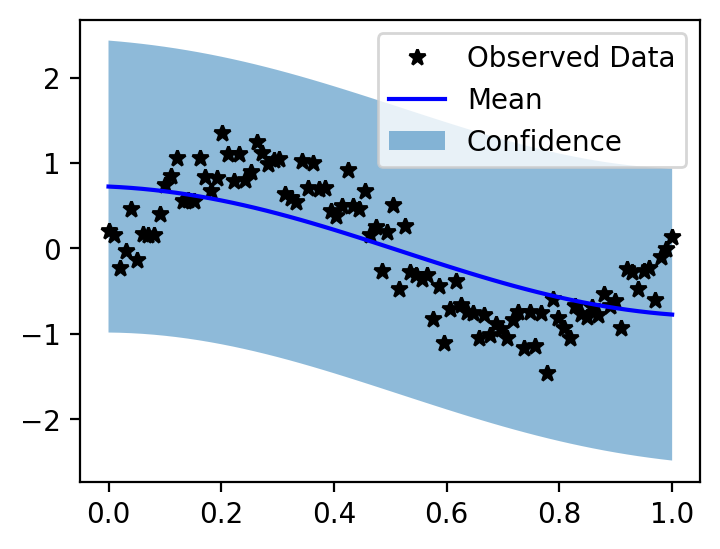

After training:
Parameter name: likelihood.noise_covar.raw_noise           value = -2.926152467727661
Parameter name: mean_module.raw_constant                   value = -0.023977229371666908
Parameter name: covar_module.raw_outputscale               value = 0.31732288002967834
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.1369012594223022


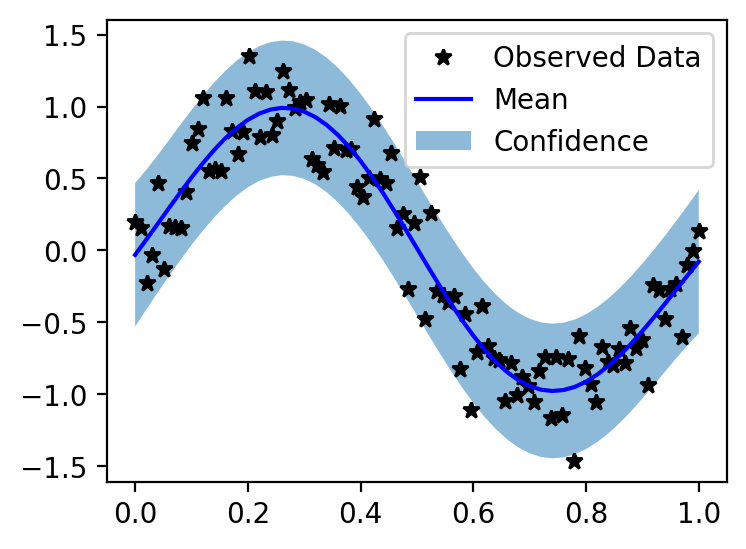

In [203]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

print("Before training:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    observed_pred = likelihood(output)

plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x)
plt.show()
# -------------------- Train --------------------------------

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

print("After training:")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    output = model(test_x)
    observed_pred = likelihood(output)

plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x)

# Bayes Opt

In [184]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
class BayesOpt:
    
    def __init__(self, learning_rate=0.1):
    
        # initialize likelihood and model
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gp = ExactGPModel(train_x, train_y, likelihood)
        self.learning_rate = learning_rate
        
    def predict(test_x)
        
        # Get into evaluation (predictive posterior) mode
        self.gp.eval()
        self.likelihood.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = self.gp(test_x)
            observed_pred = self.likelihood(output)
        return observed_pred
            
    def ucb_acquistion_f(self, x, gamma=0.2):
        # a(x;λ)=μ(x)+λσ(x)
        test_x = torch.linspace(0, 1, 51)
        observed_pred = self.predict(test_x)
        ucb = observed_pred.mean + gamma*observed_pred.stddev
        return test_x[torch.argmin(ucb)]
        
    def fit_gp(self):
    
        # Find optimal model hyperparameters
        self.gp.train()
        self.likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.gp.parameters(), lr=self.learning_rate)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(100):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()

        print("After training:")
        for param_name, param in model.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        # Test points are regularly spaced along [0,1]
        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(0, 1, 51)
            output = model(test_x)
            observed_pred = likelihood(output)

        plot(observed_pred, train_x=train_x, train_y=train_y, test_x=test_x)

# Model activity

In [38]:
def f(a=-0.1):
    x = np.linspace(0, 24, 100)
    y= a*x**4 + 0.3*x**3 + 3*x**2 - 4*x +10
    plt.plot(x, y)

In [39]:
interact(f, a=widgets.FloatSlider(min=-1, max=1, step=0.000, value=1));

interactive(children=(FloatSlider(value=1.0, description='a', max=1.0, min=-1.0, step=0.0), Output()), _dom_cl…